# SISO

QPSK Symbols 16
OFDM Symbols [-0.44194174-0.08838835j -0.19714513+0.11827184j  0.22411165+0.2392767j
 -0.2743097 -0.05456359j -0.1767767 +0.j         -0.01401067-0.2472131j
  0.15088835-0.0625j      0.25449561-0.17004853j -0.08838835-0.26516504j
  0.19714513-0.04504853j -0.40088835+0.1142767j   0.0243097 -0.1222131j
  0.        +0.j          0.01401067-0.17956359j  0.02588835+0.0625j
 -0.00449561-0.00672816j -0.44194174-0.08838835j -0.19714513+0.11827184j
  0.22411165+0.2392767j  -0.2743097 -0.05456359j]
decoded_symbols 16
decoded_noisy_symbols 16


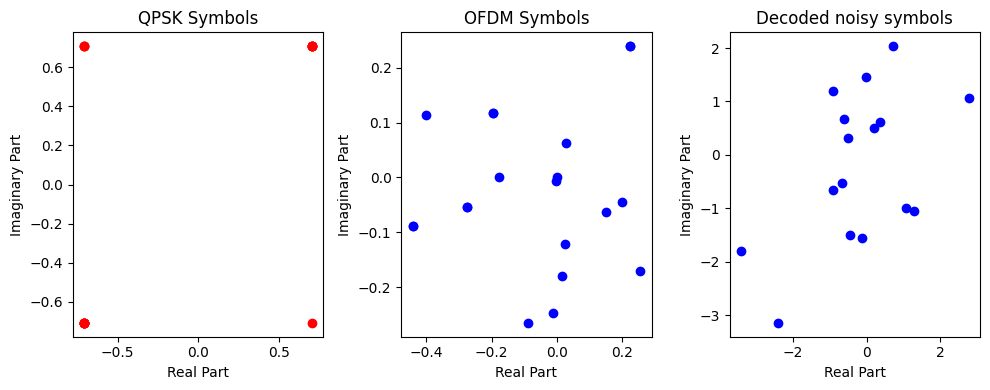

In [1]:
import numpy as np
import matplotlib.pyplot as plt


# OFDM Parameters
NCP = 4
NFFT = 16

def ofdm_modulation(symbols):
    num_symbols = len(symbols)
    num_ofdm_symbols = num_symbols // NFFT

    ofdm_symbols = []

    for i in range(num_ofdm_symbols):
        symbol_start = i * NFFT
        symbol_end = symbol_start + NFFT

        current_symbols = symbols[symbol_start:symbol_end]
        time_domain_waveform = np.fft.ifft(current_symbols)

        ofdm_symbols += list(time_domain_waveform[-NCP:])
        ofdm_symbols += list(time_domain_waveform)

    ofdm_symbols = np.array(ofdm_symbols)

    return ofdm_symbols
#do pulse shaping
def ofdm_demodulation(received_signal,h,NCP,NFFT):
    decoded_symbols = []
    path_gains_h=h
    y=received_signal
    for i in range(SYMBOLS // NFFT):
            current_symbols = np.fft.fft(y[(NFFT + NCP) * i + NCP:(NFFT + NCP) * i + NCP + NFFT])#removing circular convolution
            decoded_symbols += list(current_symbols / np.fft.fft(path_gains_h, NFFT))#h is zero padded
    decoded_symbols = np.array(decoded_symbols)

    return decoded_symbols

def add_noise(waveform_sequence, noise_std_dev):
    noise = np.random.normal(0, noise_std_dev, len(waveform_sequence)) + 1j * np.random.normal(0, noise_std_dev, len(waveform_sequence))
    noisy_waveform_sequence = waveform_sequence + noise
    return noisy_waveform_sequence

# Example usage
SYMBOLS = 16
qpsk_symbols = (np.sign(np.random.rand(SYMBOLS) - 0.5) + 1j * np.sign(np.random.rand(SYMBOLS) - 0.5)) / np.sqrt(2)
print("QPSK Symbols",len(qpsk_symbols))

# OFDM modulation
ofdm_symbols = ofdm_modulation(qpsk_symbols)
print("OFDM Symbols",ofdm_symbols)
# Define path gains

path_gains_h = [0.8 + 0.6j, 0.5 - 0.3j, 0.3 + 0.9j]  # Complex path gains for each path

y = np.convolve(path_gains_h, ofdm_symbols) # ADD NOISE HERE
noise_std_dev = 0.3
y_noisy=add_noise(y, noise_std_dev)

decoded_symbols =  ofdm_demodulation(y,path_gains_h,NCP,NFFT)
decoded_noisy_symbols = ofdm_demodulation(y_noisy,path_gains_h,NCP,NFFT)
print("decoded_symbols",len(decoded_symbols))
print("decoded_noisy_symbols",len(decoded_noisy_symbols))


# Plotting
plt.figure(figsize=(10, 4))

# Plot transmitted waveforms
plt.subplot(1, 3, 2)
plt.plot(np.real(ofdm_symbols), np.imag(ofdm_symbols), 'bo')
plt.title('OFDM Symbols')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')

# Plot received waveforms
plt.subplot(1, 3, 1)
plt.plot(np.real(qpsk_symbols), np.imag(qpsk_symbols), 'ro')
plt.title('QPSK Symbols')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')

# Plot received waveforms
plt.subplot(1, 3, 3)
plt.plot(np.real(decoded_noisy_symbols), np.imag(decoded_noisy_symbols), 'bo')
plt.title('Decoded noisy symbols')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')


plt.tight_layout()
plt.show()


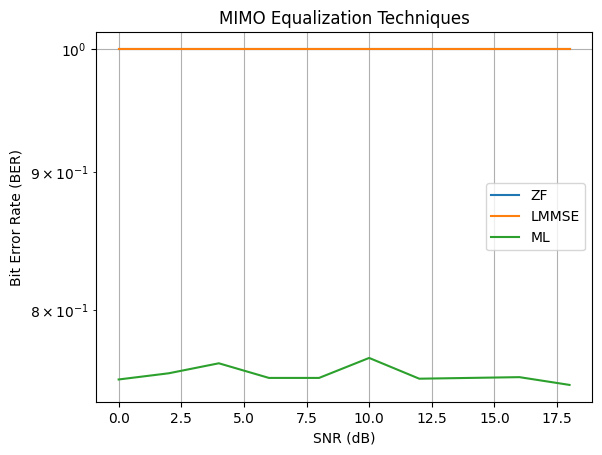

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
num_symbols = 1000  # Number of transmitted symbols
num_antennas_tx = 2  # Number of transmit antennas
num_antennas_rx = 2  # Number of receive antennas
modulation_order = 4  # Modulation order (QAM)
snr_range = np.arange(0, 20, 2)  # SNR range for simulation

# Generate transmitted symbols (QAM)
transmitted_symbols = np.random.randint(0, modulation_order, (num_antennas_tx, num_symbols))

# Generate random channel matrix
H = np.random.randn(num_antennas_rx, num_antennas_tx) + 1j * np.random.randn(num_antennas_rx, num_antennas_tx)

# Simulate MIMO transmission and reception
received_symbols = np.dot(H, transmitted_symbols)

# BER results container for different equalization techniques
ber_zf = []
ber_lmmse = []
ber_ml = []

# Simulate for different SNR levels
for snr in snr_range:
    noise_power = 10**(-snr / 10)
    noise = np.sqrt(noise_power / 2) * (np.random.randn(num_antennas_rx, num_symbols) + 1j * np.random.randn(num_antennas_rx, num_symbols))
    received_symbols_with_noise = received_symbols + noise

    # Equalization techniques (ZF, LMMSE, ML)
    equalized_symbols_zf = np.dot(np.linalg.pinv(H), received_symbols_with_noise)
    equalized_symbols_lmmse = np.dot(np.dot(np.linalg.inv(np.dot(H, H.conj().T) + noise_power * np.eye(num_antennas_rx)), H), received_symbols_with_noise)
    equalized_symbols_ml = np.argmax(np.abs(received_symbols_with_noise - np.dot(H, transmitted_symbols))**2, axis=0)

    # Calculate BER for each technique
    ber_zf.append(np.sum(equalized_symbols_zf != transmitted_symbols) / (num_antennas_tx * num_symbols))
    ber_lmmse.append(np.sum(equalized_symbols_lmmse != transmitted_symbols) / (num_antennas_tx * num_symbols))
    ber_ml.append(np.sum(equalized_symbols_ml != transmitted_symbols) / (num_antennas_tx * num_symbols))

# Plot BER vs SNR
plt.semilogy(snr_range, ber_zf, label='ZF')
plt.semilogy(snr_range, ber_lmmse, label='LMMSE')
plt.semilogy(snr_range, ber_ml, label='ML')
plt.xlabel('SNR (dB)')
plt.ylabel('Bit Error Rate (BER)')
plt.title('MIMO Equalization Techniques')
plt.legend()
plt.grid()
plt.show()



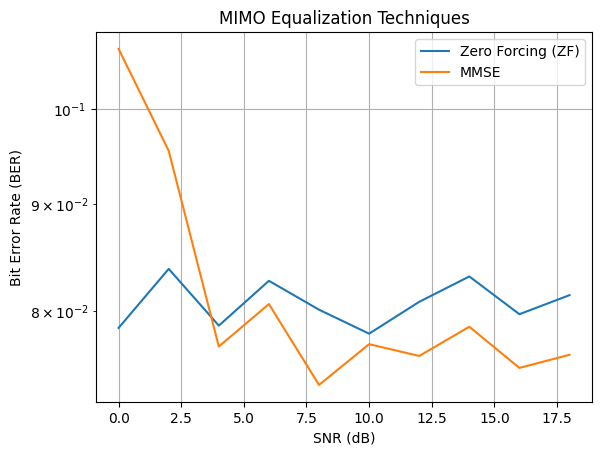

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
num_symbols = 5000  # Number of transmitted symbols
num_antennas_tx = 2  # Number of transmit antennas
num_antennas_rx = 2  # Number of receive antennas
modulation_order = 4  # Modulation order (QAM)
snr_range = np.arange(0, 20, 2)  # SNR range for simulation

# Generate transmitted symbols (QAM)
transmitted_symbols = np.random.randint(0, modulation_order, (num_antennas_tx, num_symbols))

# Generate random channel matrix
H = np.random.randn(num_antennas_rx, num_antennas_tx) + 1j * np.random.randn(num_antennas_rx, num_antennas_tx)

# Simulate MIMO transmission and reception
received_symbols = np.dot(H, transmitted_symbols)

# BER results containers for different equalization techniques
ber_zf = []
ber_mmse = []

# Simulate for different SNR levels
for snr in snr_range:
    noise_power = 10**(-snr / 10)
    noise = np.sqrt(noise_power / 2) * (np.random.randn(num_antennas_rx, num_symbols) + 1j * np.random.randn(num_antennas_rx, num_symbols))
    received_symbols_with_noise = received_symbols + noise

    # Zero-Forcing (ZF) Equalization
    equalized_symbols_zf = np.dot(np.linalg.pinv(H), received_symbols_with_noise)

    # MMSE Equalization
    H_Hermitian = H.conj().T
    mmse_denominator = np.dot(H, H_Hermitian) + noise_power * np.eye(num_antennas_rx)
    mmse_coefficients = np.dot(H_Hermitian, np.linalg.inv(mmse_denominator))
    equalized_symbols_mmse = np.dot(mmse_coefficients, received_symbols_with_noise)

    # Calculate BER for each technique
    ber_zf.append(np.sum(np.argmax(np.abs(equalized_symbols_zf - transmitted_symbols), axis=0)) / (num_antennas_tx * num_symbols))
    ber_mmse.append(np.sum(np.argmax(np.abs(equalized_symbols_mmse - transmitted_symbols), axis=0)) / (num_antennas_tx * num_symbols))

# Plot BER vs SNR
plt.semilogy(snr_range, ber_zf, label='Zero Forcing (ZF)')
plt.semilogy(snr_range, ber_mmse, label='MMSE')
plt.xlabel('SNR (dB)')
plt.ylabel('Bit Error Rate (BER)')
plt.title('MIMO Equalization Techniques')
plt.legend()
plt.grid()
plt.show()


# **MISO**

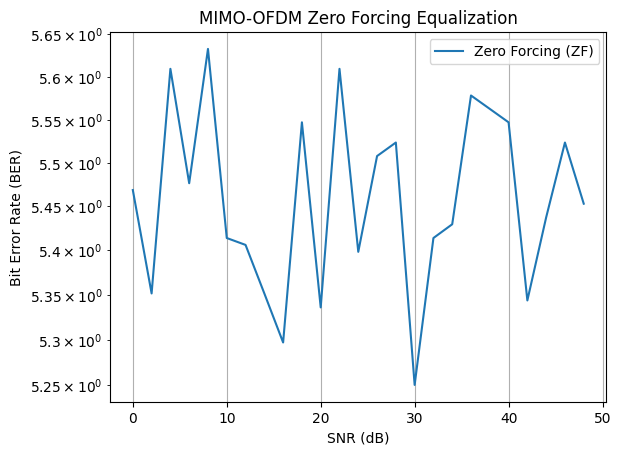

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
num_symbols = 1000  # Number of transmitted symbols
num_antennas_tx = 2  # Number of transmit antennas
num_antennas_rx = 2  # Number of receive antennas
modulation_order = 4  # Modulation order (QAM)
snr_range = np.arange(0, 50, 2)  # SNR range for simulation
num_subcarriers = 64  # Number of OFDM subcarriers

# Generate random transmitted symbols (QAM)
transmitted_symbols = np.random.randint(0, modulation_order, (num_antennas_tx, num_symbols))

# Generate random channel matrix
H = np.random.randn(num_antennas_rx, num_antennas_tx) + 1j * np.random.randn(num_antennas_rx, num_antennas_tx)

# Simulate MIMO transmission and reception
received_symbols = np.dot(H, transmitted_symbols)

# BER results container for Zero-Forcing (ZF) equalization
ber_zf = []

# Simulate for different SNR levels
for snr in snr_range:
    noise_power = 10**(-snr / 10)
    noise = np.sqrt(noise_power / 2) * (np.random.randn(num_antennas_rx, num_symbols) + 1j * np.random.randn(num_antennas_rx, num_symbols))
    received_symbols_with_noise = received_symbols + noise

    # OFDM Modulation
    transmitted_ofdm_symbols = np.sqrt(num_subcarriers) * np.fft.ifft(transmitted_symbols, axis=0)

    # Apply channel to transmitted OFDM symbols
    received_ofdm_symbols = np.dot(H, transmitted_ofdm_symbols)

    # Apply noise to received OFDM symbols
    received_ofdm_symbols_with_noise = received_ofdm_symbols + noise

    # Zero-Forcing (ZF) Equalization
    equalized_ofdm_symbols_zf = np.dot(np.linalg.pinv(H), received_ofdm_symbols_with_noise)

    # Calculate BER for ZF equalization
    ber_zf.append(np.sum(np.argmax(np.abs(equalized_ofdm_symbols_zf - transmitted_ofdm_symbols), axis=0)) / (num_antennas_tx * num_subcarriers))

# Plot BER vs SNR
plt.semilogy(snr_range, ber_zf, label='Zero Forcing (ZF)')
plt.xlabel('SNR (dB)')
plt.ylabel('Bit Error Rate (BER)')
plt.title('MIMO-OFDM Zero Forcing Equalization')
plt.legend()
plt.grid()
plt.show()


<ipython-input-10-694b2a97300e>:43: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  ber_ml.append(np.sum(equalized_ofdm_symbols_ml != transmitted_symbols) / (num_antennas_tx * num_symbols))


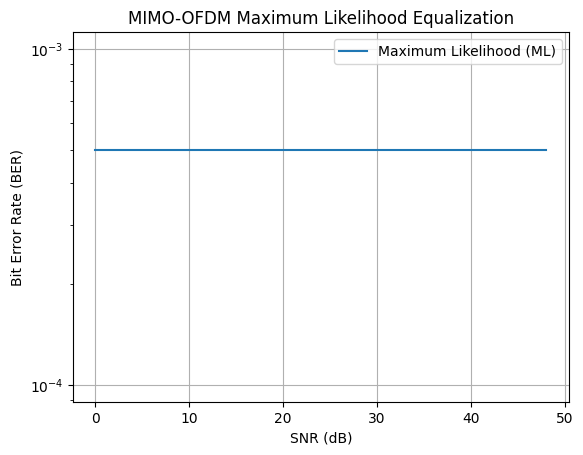

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
num_symbols = 1000  # Number of transmitted symbols
num_antennas_tx = 2  # Number of transmit antennas
num_antennas_rx = 2  # Number of receive antennas
modulation_order = 4  # Modulation order (QAM)
snr_range = np.arange(0, 50, 2)  # SNR range for simulation
num_subcarriers = 64  # Number of OFDM subcarriers

# Generate random transmitted symbols (QAM)
transmitted_symbols = np.random.randint(0, modulation_order, (num_antennas_tx, num_symbols))

# Generate random channel matrix
H = np.random.randn(num_antennas_rx, num_antennas_tx) + 1j * np.random.randn(num_antennas_rx, num_antennas_tx)

# Simulate MIMO transmission and reception
received_symbols = np.dot(H, transmitted_symbols)

# BER results container for Maximum Likelihood (ML) equalization
ber_ml = []

# Simulate for different SNR levels
for snr in snr_range:
    noise_power = 10**(-snr / 10)
    noise = np.sqrt(noise_power / 2) * (np.random.randn(num_antennas_rx, num_symbols) + 1j * np.random.randn(num_antennas_rx, num_symbols))
    received_symbols_with_noise = received_symbols + noise

    # OFDM Modulation
    transmitted_ofdm_symbols = np.sqrt(num_subcarriers) * np.fft.ifft(transmitted_symbols, axis=0)

    # Apply channel to transmitted OFDM symbols
    received_ofdm_symbols = np.dot(H, transmitted_ofdm_symbols)

    # Apply noise to received OFDM symbols
    received_ofdm_symbols_with_noise = received_ofdm_symbols + noise

    # Maximum Likelihood (ML) Equalization
    equalized_ofdm_symbols_ml = np.argmax(np.abs(np.expand_dims(received_ofdm_symbols_with_noise, axis=2) - np.expand_dims(H @ transmitted_ofdm_symbols, axis=1)), axis=0)

    # Calculate BER for ML equalization
    ber_ml.append(np.sum(equalized_ofdm_symbols_ml != transmitted_symbols) / (num_antennas_tx * num_symbols))

# Plot BER vs SNR
plt.semilogy(snr_range, ber_ml, label='Maximum Likelihood (ML)')
plt.xlabel('SNR (dB)')
plt.ylabel('Bit Error Rate (BER)')
plt.title('MIMO-OFDM Maximum Likelihood Equalization')
plt.legend()
plt.grid()
plt.show()


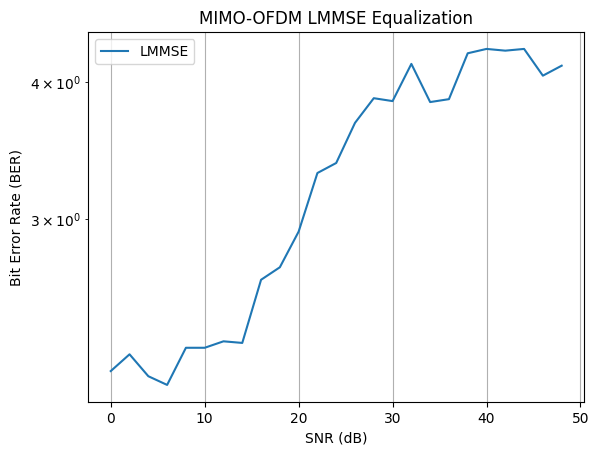

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
num_symbols = 1000  # Number of transmitted symbols
num_antennas_tx = 2  # Number of transmit antennas
num_antennas_rx = 2  # Number of receive antennas
modulation_order = 4  # Modulation order (QAM)
snr_range = np.arange(0, 50, 2)  # SNR range for simulation
num_subcarriers = 64  # Number of OFDM subcarriers

# Generate random transmitted symbols (QAM)
transmitted_symbols = np.random.randint(0, modulation_order, (num_antennas_tx, num_symbols))

# Generate random channel matrix
H = np.random.randn(num_antennas_rx, num_antennas_tx) + 1j * np.random.randn(num_antennas_rx, num_antennas_tx)

# Simulate MIMO transmission and reception
received_symbols = np.dot(H, transmitted_symbols)

# BER results container for LMMSE equalization
ber_lmmse = []

# Simulate for different SNR levels
for snr in snr_range:
    noise_power = 10**(-snr / 10)
    noise = np.sqrt(noise_power / 2) * (np.random.randn(num_antennas_rx, num_symbols) + 1j * np.random.randn(num_antennas_rx, num_symbols))
    received_symbols_with_noise = received_symbols + noise

    # OFDM Modulation
    transmitted_ofdm_symbols = np.sqrt(num_subcarriers) * np.fft.ifft(transmitted_symbols, axis=0)

    # Apply channel to transmitted OFDM symbols
    received_ofdm_symbols = np.dot(H, transmitted_ofdm_symbols)

    # Apply noise to received OFDM symbols
    received_ofdm_symbols_with_noise = received_ofdm_symbols + noise

    # LMMSE Equalization
    H_Hermitian = H.conj().T
    lmmse_denominator = np.dot(H, H_Hermitian) + noise_power * np.eye(num_antennas_rx)
    lmmse_coefficients = np.dot(H_Hermitian, np.linalg.inv(lmmse_denominator))
    equalized_ofdm_symbols_lmmse = np.dot(lmmse_coefficients, received_ofdm_symbols_with_noise)

    # Calculate BER for LMMSE equalization
    ber_lmmse.append(np.sum(np.argmax(np.abs(equalized_ofdm_symbols_lmmse - transmitted_ofdm_symbols), axis=0)) / (num_antennas_tx * num_subcarriers))

# Plot BER vs SNR
plt.semilogy(snr_range, ber_lmmse, label='LMMSE')
plt.xlabel('SNR (dB)')
plt.ylabel('Bit Error Rate (BER)')
plt.title('MIMO-OFDM LMMSE Equalization')
plt.legend()
plt.grid()
plt.show()


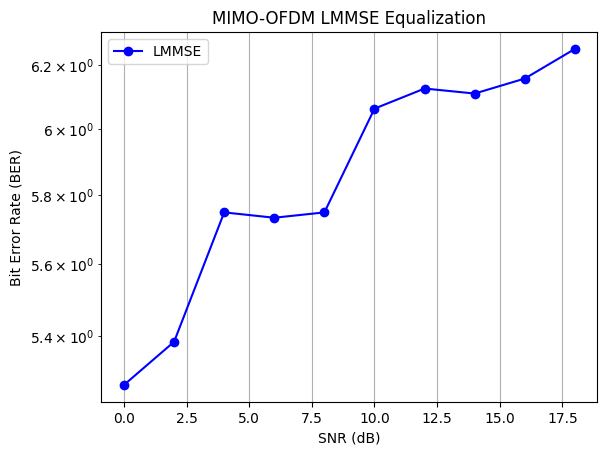

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
num_symbols = 1000  # Number of transmitted symbols
num_antennas_tx = 2  # Number of transmit antennas
num_antennas_rx = 2  # Number of receive antennas
modulation_order = 4  # Modulation order (QAM)
snr_range = np.arange(0, 20, 2)  # SNR range for simulation
num_subcarriers = 64  # Number of OFDM subcarriers

# Generate random transmitted symbols (QAM)
transmitted_symbols = np.random.randint(0, modulation_order, (num_antennas_tx, num_symbols))

# Generate random channel matrix
H = np.random.randn(num_antennas_rx, num_antennas_tx) + 1j * np.random.randn(num_antennas_rx, num_antennas_tx)

# Simulate MIMO transmission and reception
received_symbols = np.dot(H, transmitted_symbols)

# BER results container for LMMSE equalization
ber_lmmse = []

# Simulate for different SNR levels
for snr in snr_range:
    noise_power = 10**(-snr / 10)
    noise = np.sqrt(noise_power / 2) * (np.random.randn(num_antennas_rx, num_symbols) + 1j * np.random.randn(num_antennas_rx, num_symbols))
    received_symbols_with_noise = received_symbols + noise

    # OFDM Modulation
    transmitted_ofdm_symbols = np.sqrt(num_subcarriers) * np.fft.ifft(transmitted_symbols, axis=0)

    # Apply channel to transmitted OFDM symbols
    received_ofdm_symbols = np.dot(H, transmitted_ofdm_symbols)

    # Apply noise to received OFDM symbols
    received_ofdm_symbols_with_noise = received_ofdm_symbols + noise

    # LMMSE Equalization
    H_Hermitian = H.conj().T
    lmmse_denominator = np.dot(H, H_Hermitian) + noise_power * np.eye(num_antennas_rx)
    lmmse_coefficients = np.dot(H_Hermitian, np.linalg.inv(lmmse_denominator))
    equalized_ofdm_symbols_lmmse = np.dot(lmmse_coefficients, received_ofdm_symbols_with_noise)

    # Calculate BER for LMMSE equalization
    ber = np.sum(np.argmax(np.abs(equalized_ofdm_symbols_lmmse - transmitted_ofdm_symbols), axis=0) != 0) / (num_antennas_tx * num_subcarriers)
    ber_lmmse.append(ber)

# Plot BER vs SNR
plt.semilogy(snr_range, ber_lmmse, marker='o', linestyle='-', color='b', label='LMMSE')
plt.xlabel('SNR (dB)')
plt.ylabel('Bit Error Rate (BER)')
plt.title('MIMO-OFDM LMMSE Equalization')
plt.legend()
plt.grid()
plt.show()
